In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [ ]:
df = pd.read_csv('../input/flavors_of_cacao.csv',na_values='\xa0')

let's check for some missing values first

In [ ]:
b = pd.DataFrame(df.isnull().sum(), columns= ['Number of missing values'])
b

In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(df['Rating'],bins=5,color='brown')

The distribution of the ratings is somewhat skewed from normal. We see that there is a high number of  3 and 4 ratings. There are very few 1 and 5 ratings.

Extracted the Cocoa percentage and converted it into float for further analysis

In [ ]:
df['Cocoa % as num'] = df['Cocoa\nPercent'].apply(lambda x: x.split('%')[0])
df['Cocoa % as num'] = df['Cocoa % as num'].astype(float)

Cocoa is a key ingredient of any chocolate. Now, lets look at the distribution of cocoa percentage.
As expected, we see that the distribution of cocoa percentage in chocolates is normally distributed with a majority of the chocolates having 70% of cocoa.

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(df['Cocoa % as num'],bins=20,color='Brown')

Let's have a look at the ratings by Review year, we would like to see if the review date has an effect on the Rating. Also, we would like to see if the outliers in the Rating. A boxplot would be very helpful in this case.

In [ ]:
df['Review\nDate'] = df['Review\nDate'].astype(str)

plt.figure(figsize=(12,6))
sns.boxplot(x='Review\nDate', y='Rating',data=df)

There is an interesting trend in the Rating. From the years 2006 to 2009, the median of the Ratings is consistent around 3. There is a jump in the median to a value of 3.3 from 2010 and it remained around 3.3 until 2016. 

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,figsize=(12,15))


a = df.groupby(['Company\nLocation'])['Rating'].mean()
a = a.sort_values(ascending=False)

b = df.groupby(['Company\nLocation'])['Rating'].median()
b = b.sort_values(ascending=False)

a = pd.DataFrame(a)
b = pd.DataFrame(b)

Ratings_by_location = a.join(b, how='left',lsuffix='_mean', rsuffix='_median')
Ratings_by_location['Mean-Median'] = Ratings_by_location['Rating_mean']-Ratings_by_location['Rating_median']
Rating_difference = sns.barplot(x=Ratings_by_location.index,y=Ratings_by_location['Mean-Median'], ax = ax3)
Rating_difference.set_xticklabels(labels = Ratings_by_location.index, rotation =90)
Rating_difference.set_ylabel("Mean-Median of ratings")


#plt.figure(figsize=(12,6))
ratings_mean = sns.barplot(x=Ratings_by_location.index,y=Ratings_by_location['Rating_mean'],ax=ax1)
ratings_mean.set_xticklabels(labels = Ratings_by_location.index, rotation =90)
ratings_mean.set_ylabel("Mean of Ratings")


#plt.figure(figsize=(12,6))
ratings_median = sns.barplot(x=Ratings_by_location.index,y=Ratings_by_location['Rating_median'], ax = ax2)
ratings_median.set_xticklabels(labels = Ratings_by_location.index, rotation =90)
ratings_median.set_ylabel("Median of ratings")

plt.tight_layout()

From the above visualizations, we can see that there is no much difference between mean and median of the data except for the company that's located in Sao Tome.

A very important observation is that, Rating seems to be dependent on the country of company location.
We can spot several European and South American countries with a higher mean Rating, this could be due to the availability of Cocoa in these countries. The availability cocoa can influence the percentage of Cocoa used in the chocolates at these companies.

Lets looks at the Cocoa percentage used in Chocolates in different countries. 
From the below chart, the distribution of cocoa varied from 40% to around 80% in our dataset. 

In [ ]:
plt.figure(figsize=(12,6))

c = df.groupby(['Company\nLocation'])['Cocoa % as num'].mean()
c = c.sort_values(ascending=False)

ratings = sns.barplot(x=c.index,y=c)
ratings.set_xticklabels(labels = c.index, rotation =90)

The Ratings might be possibly influenced by the bean type and broad bean type used in the production.
Since we have these features in our dataset, we can plot the effect these features have on our ratings.

From the below visualizations, we can see that the distribution of ratings is different based on bean type and broad bean type.

In [ ]:

fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(12,15))

e = df.groupby(['Bean\nType'])['Rating'].mean()
e = e.sort_values(ascending=False)
Rating_beanType = sns.barplot(y=e.index,x=e,ax = ax1)


f = df.groupby(['Broad Bean\nOrigin'])['Rating'].mean()
f = f.sort_values(ascending=False)
Rating_broadbean = sns.barplot(y=f.index,x=f,ax = ax2)

plt.tight_layout()

Soon to be added: Will try to spot anomalies in this dataset using techniques like DBScan.

We have chosen Cocoa percentage, Review date, Rating, Broad bean origin, Company location to be included in the training data for our clustering model.

The clustering technique we will be using is DBScan

Density-based spatial clustering of applications with noise (DBSCAN) is a data clustering algorithm proposed by Martin Ester, Hans-Peter Kriegel, Jörg Sander and Xiaowei Xu in 1996. It is a density-based clustering algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). DBSCAN is one of the most common clustering algorithms and also most cited in scientific literature.

In 2014, the algorithm was awarded the test of time award (an award given to algorithms which have received substantial attention in theory and practice) at the leading data mining conference, KDD.

Source: Wikipedia


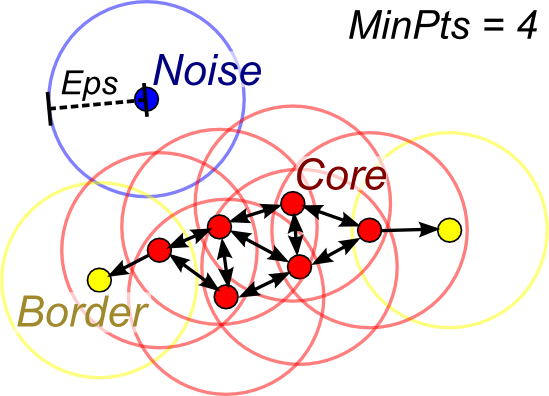


The above figure is taken from https://stats.stackexchange.com/questions/194734/dbscan-what-is-a-core-point

Blue observations are noise

Red observations are core points

Yellow ones are non core point aka edges of the cluster



In [ ]:
df1 = df[['Cocoa % as num','Rating','Review\nDate']]

In [ ]:
#non_numerical_columns = ['Review\nDate','Bean\nType', 'Broad Bean\nOrigin','Company\nLocation']

non_numerical_columns = ['Review\nDate']

for i in non_numerical_columns:
    x1 = pd.get_dummies(df1[i])
    df1 = df1.join(x1,lsuffix='_l',rsuffix='_r')
    df1.drop(i,axis=1,inplace=True)

Standardizing the data is key for most of the clustering techniques to avoid a feature biasing the results of clustering

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [ ]:
df_num = StandardScaler().fit_transform(df1)

In [ ]:
A = []
B = []
C = []

for i in np.linspace(0.1,5,50):
    db = DBSCAN(eps=i, min_samples=10).fit(df_num)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    sum = 0
    for t in labels:
        if t == -1: 
            sum = sum + 1
    C.append(sum)
            
    
    
    A.append(i)
    B.append(int(n_clusters_))

labels are the label of the clusters.
If the label is -1, then the observation is an outlier/noise within our dataset.


db.core_sample_indices_   are the indices of the core points in the cluster, the indices that are excluded here are of outliers and the edges of the clusters

In [ ]:
results = pd.DataFrame([A,B,C]).T
results.columns = ['distance','Number of clusters','Number of outliers']
results.plot(x='distance',y='Number of clusters',figsize=(10,6))

Based on the above plot, I decided to go forward with a distance (epsilon) value of 1

In [ ]:
db = DBSCAN(eps=1, min_samples=10).fit(df_num)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

The number of clusters in our dataset is 12. Remember that the number of clusters does not include outliers/noise in the dataset.

In [ ]:
df = df.join(pd.DataFrame(labels))
df = df.rename(columns={0:'Cluster'})

df['Cluster'].value_counts()

-1 stands for outliers/Noise, we see that there are 93 outliers in our dataset. 

The number of observations in our clusters range from 20 to 283.

Let's look at some statistics within our clusters.

In [ ]:
df_clusters = df.groupby('Cluster')['Rating','Cocoa % as num']
df_clusters.describe()

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows = 2,figsize=(12,12))

plt.figure(figsize=(12,8))
plot1 = sns.boxplot(x=df['Cluster'],y=df['Rating'],data=df, ax = ax1)


plt.figure(figsize=(12,8))
plot2 = sns.boxplot(x=df['Cluster'],y=df['Cocoa % as num'],data=df, ax= ax2)

We can infer from the above plots that the rating as well as the Cocoa percentage is much different for our outliers from the remaining clusters within the dataset.

A high Cocoa percentage in a chocolate doesn't necessarily prompt higher ratings, looks like it actually worsens the ratings from our dataset.

The following code is actually taken from scikit learn for visualization of our clusters.

http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

In [ ]:
plt.figure(figsize=(16,12))
X = df_num

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

The black markers in the above dataset is the noise/outliers in our dataset.

More analysis to follow soon. 

Thanks, upvote if you liked it :)